<a href="https://colab.research.google.com/github/Saharsh2k5/ML_ASSIGNMENT_2/blob/main/Task2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.
Audio Reconstruction - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time
(
t
)
 to amplitude
(
A
)
, where
t
 is the time point, and
A
 is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction
 [1.5 Mark]

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

from latexify import latexify
latexify(columns = 2)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [ ]:
!wget https://dt7v1i9vyp3mf.cloudfront.net/assetlibrary/m/mediumhall.mp3?QOWBTLo6.WiuB09FkjkVqxaEKiRIWrQD -O audio.wav

--2024-09-09 19:52:09--  https://dt7v1i9vyp3mf.cloudfront.net/assetlibrary/m/mediumhall.mp3?QOWBTLo6.WiuB09FkjkVqxaEKiRIWrQD
Resolving dt7v1i9vyp3mf.cloudfront.net (dt7v1i9vyp3mf.cloudfront.net)... 99.86.37.2, 99.86.37.133, 99.86.37.164, ...
Connecting to dt7v1i9vyp3mf.cloudfront.net (dt7v1i9vyp3mf.cloudfront.net)|99.86.37.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 655150 (640K) [audio/mpeg]
Saving to: ‘audio.wav’

audio.wav           100%[===================>] 639.79K  --.-KB/s    in 0.03s   

2024-09-09 19:52:09 (18.1 MB/s) - ‘audio.wav’ saved [655150/655150]



In [ ]:
from IPython.display import Audio
Audio('audio.wav')

In [ ]:
import torchaudio
audio, sr = torchaudio.load('./audio.wav')

tm = audio.shape[1] / sr
print(f"Audio length: {tm} seconds")

Audio length: 27.206643990929706 seconds


In [ ]:
print(audio.shape)
audio = audio[0]

torch.Size([1, 1199813])


In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

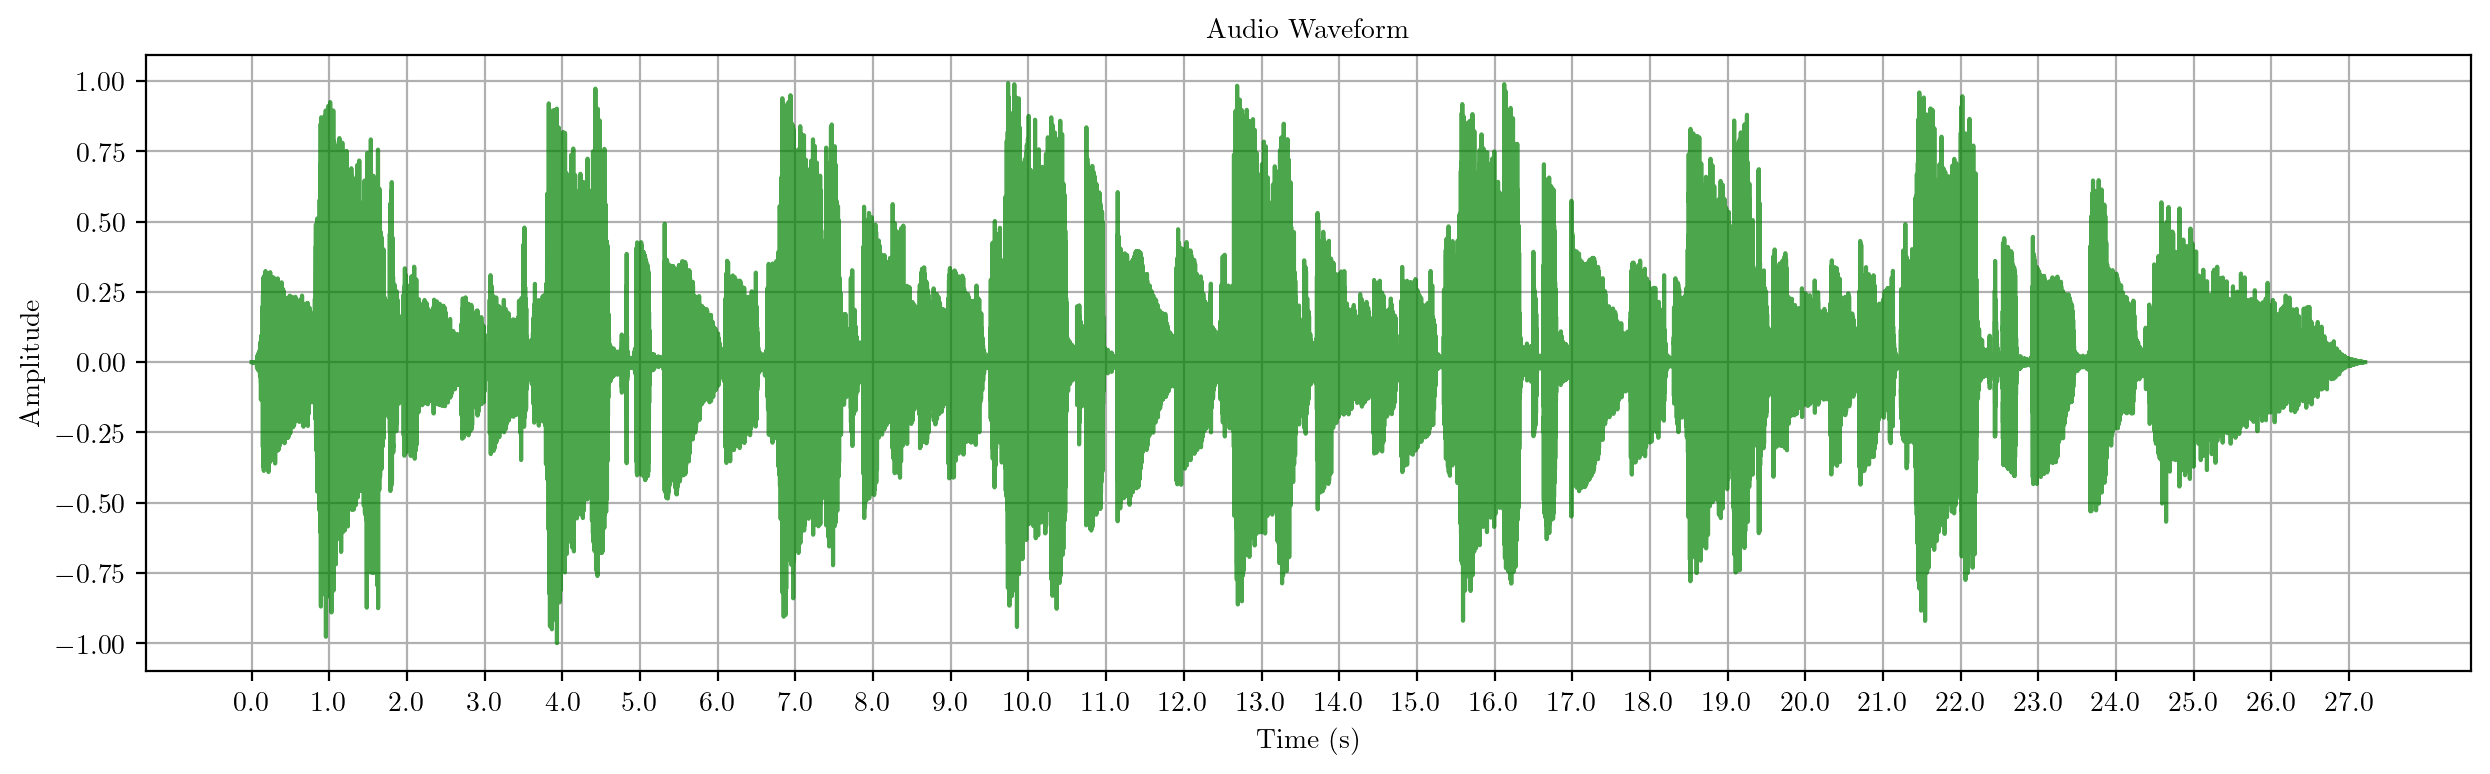

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [ ]:
start_time = 7
end_time = 12

start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

audio = audio[start_sample:end_sample]
print(audio.shape)
print(audio)

torch.Size([220500])
tensor([0.2106, 0.1649, 0.1295,  ..., 0.1589, 0.1517, 0.1456])


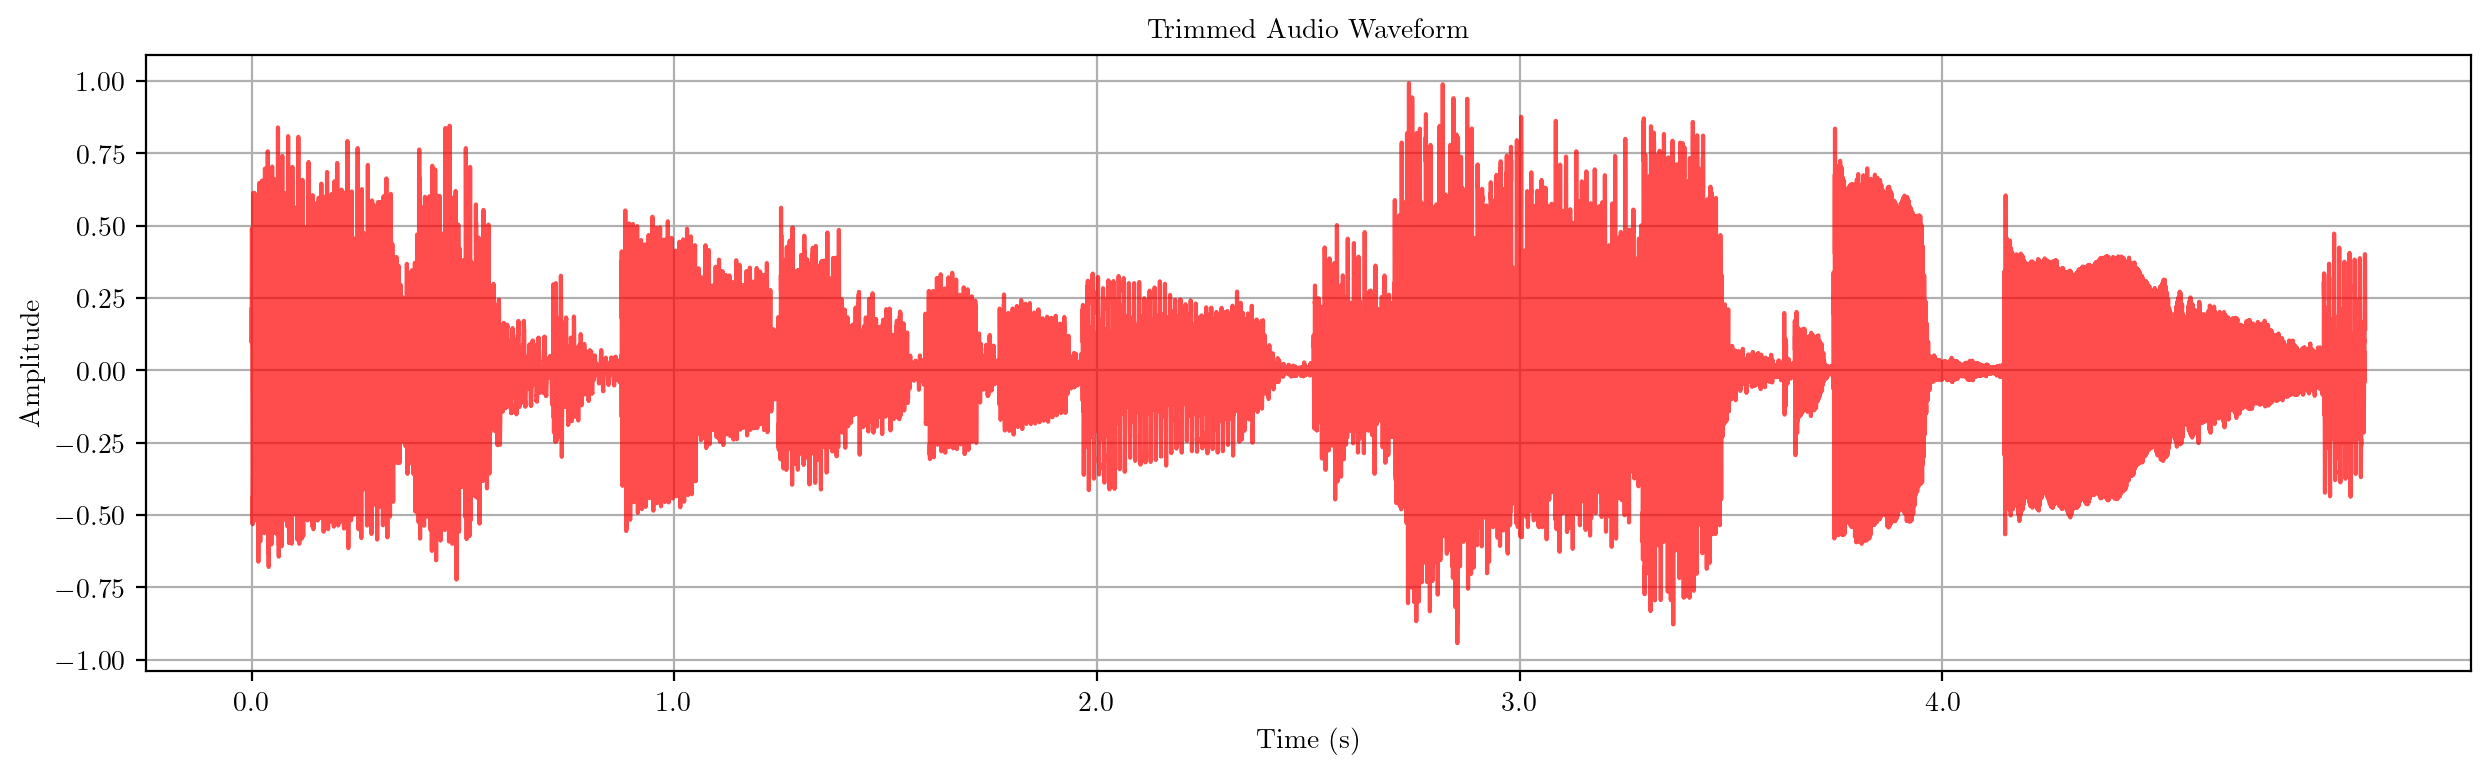

In [ ]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [ ]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
Audio(audio, rate = sr)

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [ ]:
num_features = 4000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [ ]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [ ]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(87.17476, 31404.041)

In [ ]:
Audio(pred_audio, rate = sr)

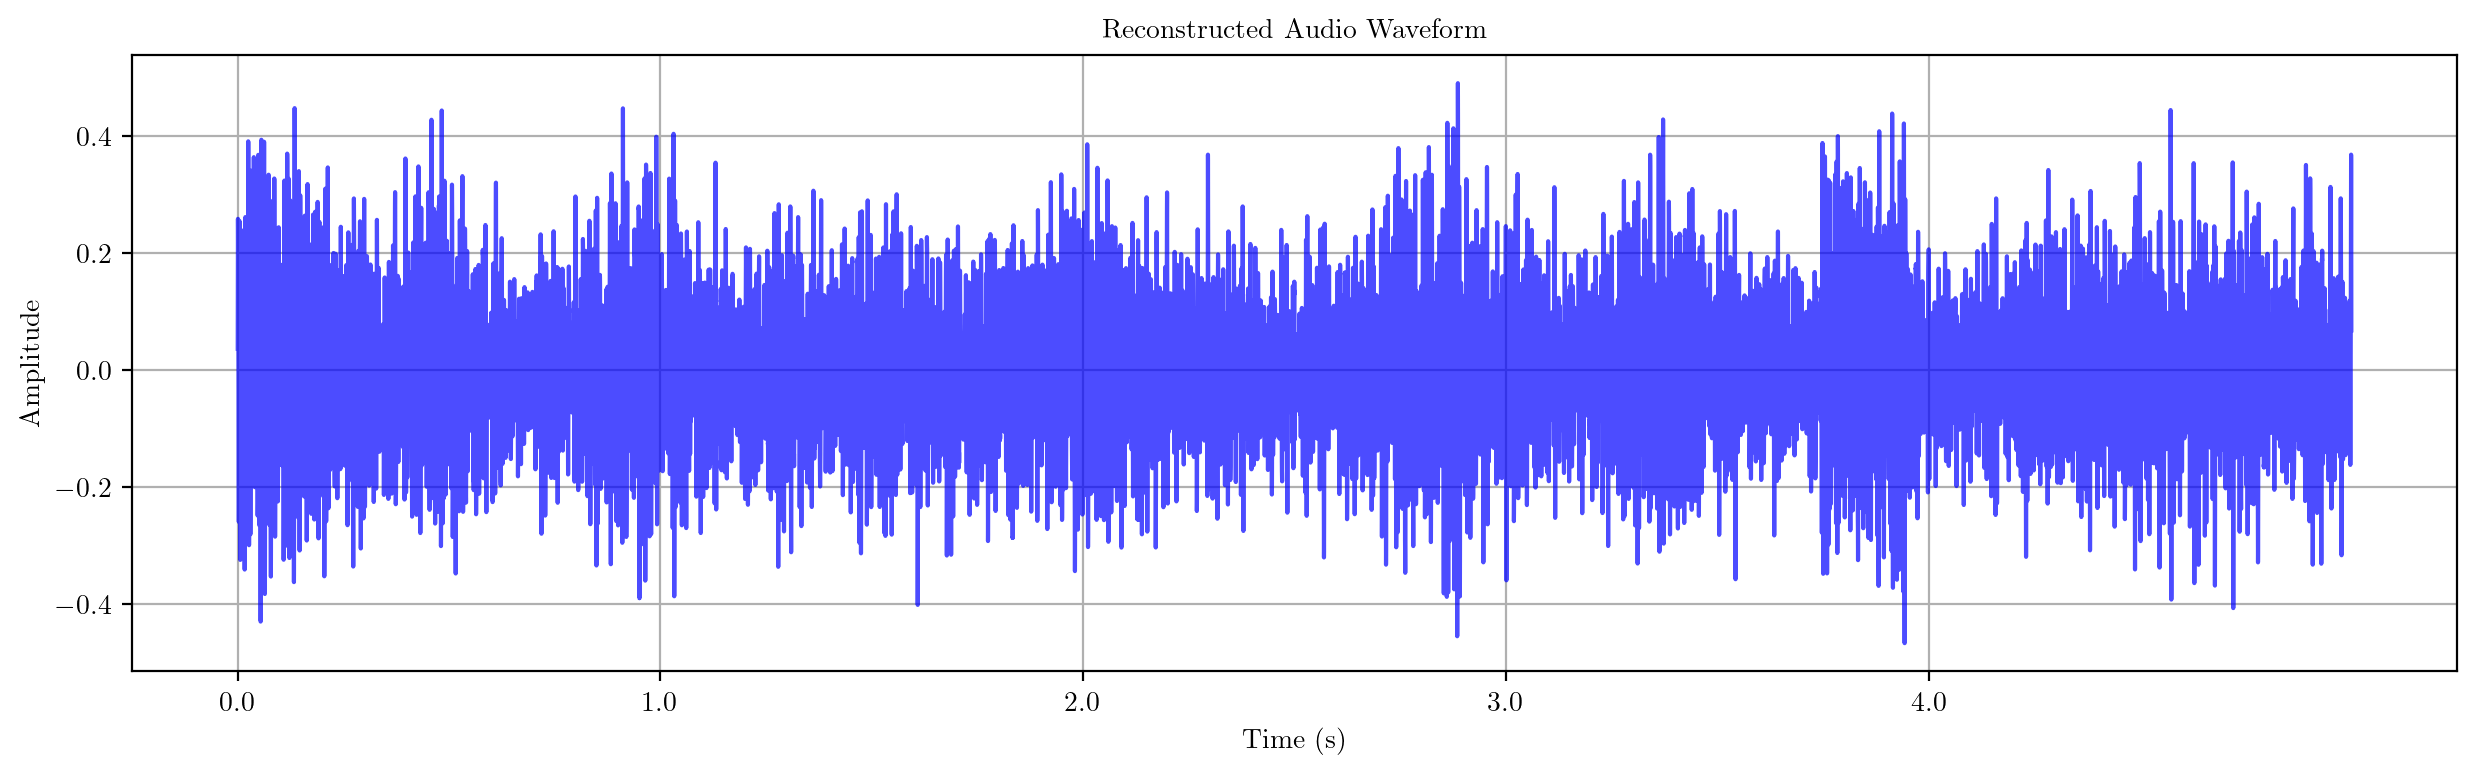

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

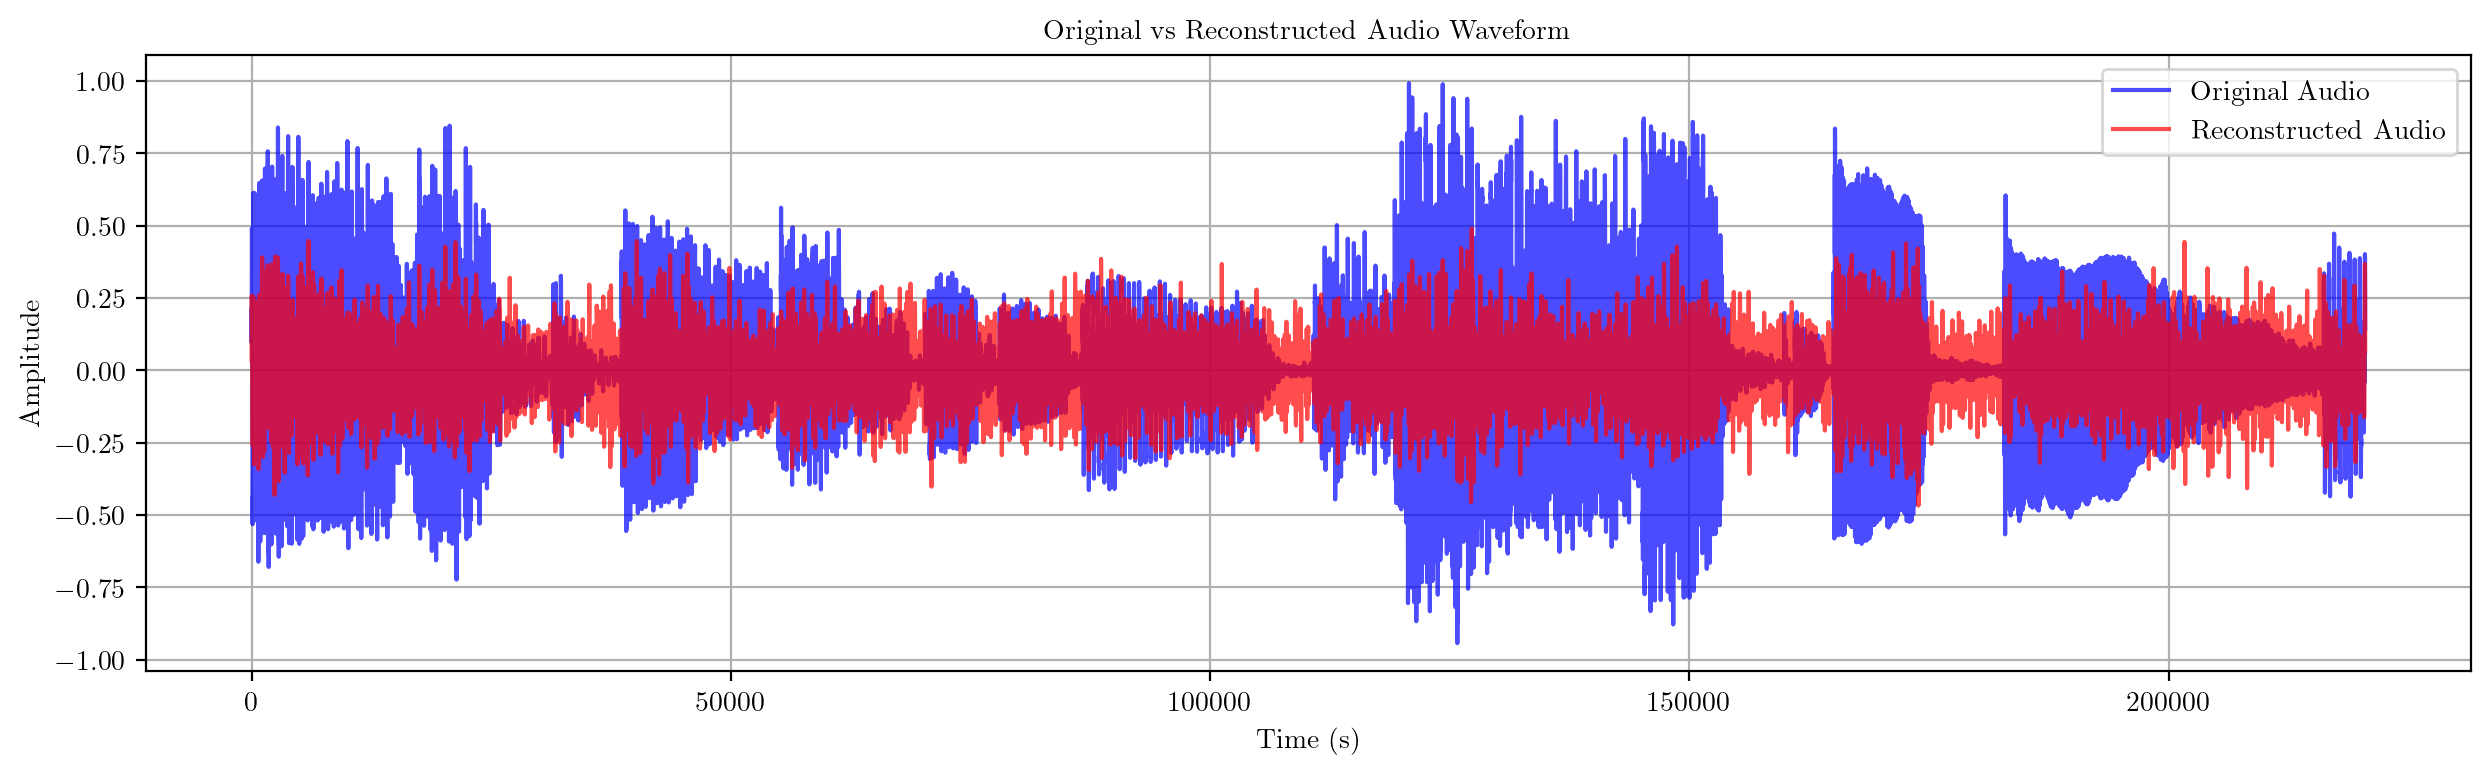

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [ ]:
import numpy as np
def RMSE(audio,pred_audio):
  rmse = np.sqrt(np.mean((audio.numpy() - pred_audio)**2))
  return rmse

def snr(audio,pred_audio):
    snr = 10 * np.log10(np.sum(audio.numpy()**2) / np.sum((audio.numpy() - pred_audio)**2))
    return snr

rmse=RMSE(audio,pred_audio)
snr=snr(audio,pred_audio)

print("Root Mean Square Error is",rmse)
print("Signal to Noise Ratio is",snr)

Root Mean Square Error is 0.18564636
Signal to Noise Ratio is 1.55593603849411
